In [236]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import scipy.stats as st
from sklearn import ensemble, tree, linear_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

In [259]:
def move_to_first_column(name, df):
    first_column = df.pop(name)
    df.insert(0, name, first_column)
    return df

def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    
    for i in range(len(df_as_np) - window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = [df_as_np[i+window_size][0], df_as_np[i+window_size][1], df_as_np[i+window_size][2], df_as_np[i+window_size][3], df_as_np[i+window_size][4], df_as_np[i+window_size][5]]
        y.append(label)
    return np.array(X), np.array(y)

# def plot_predictions(model, X, y, y_df_test, start = 0, end = 100):
#     predictions = model.predict(X)
#     p_preds = predictions[:, 0]
#     p_actuals = y[:, 0]
# #     n_preds = predictions[:, 1]
#     n_actuals = y[:, 1]
    
#     list_Year = [str(i).split(" ")[0][0:4] for i in list(y_df_test.index)]
#     list_YM = [str(i).split(" ")[0][:-3] for i in  list(y_df_test.index)]
    
#     df = pd.DataFrame(data = {
# #         'PM10 predictions': p_preds,
#                                  'PM10 actuals': p_actuals,
# #                               'Noise predictions': n_preds,
#                               'Noise actuals': n_actuals,
#         #11_oktomvri_pm10
#                                 '11_oktomvri_sensor_id': y_df_test['11_oktomvri_sensor_id'],
#                               '11_oktomvri_log': y_df_test['11_oktomvri_log'],
#                               '11_oktomvri_lat': y_df_test['11_oktomvri_lat'],
#         'zhelezhara_sensor_id': y_df_test['zhelezhara_sensor_id'],
#                               'zhelezhara_log': y_df_test['zhelezhara_log'],
#                               'zhelezhara_lat': y_df_test['zhelezhara_lat']
#                              })
    
#     df['Year'] = list_Year
#     df['YM'] = list_YM
    
#     df_yearly = df.groupby(['11_oktomvri_sensor_id', '11_oktomvri_lat', '11_oktomvri_log', 'zhelezhara_sensor_id', 'zhelezhara_log', 'zhelezhara_lat', 'Year', 'YM']).mean()
#     df_yearly = df_yearly[['PM10 actuals', 'Noise actuals']].reset_index()
#     sns.set_style('darkgrid')
#     sns.set(rc={'figure.figsize':(14,8)})

#     bx = sns.lineplot(data=df_yearly, x ='YM', y = 'PM10 actuals', label = 'PM10 actual values')
#     dx = sns.lineplot(data=df_yearly, x ='YM', y = 'Noise actuals', label = 'Noise actual values')


#     plt.legend(bbox_to_anchor=(1, 1))
#     plt.ylabel('PM10 (µg/m3)')
#     plt.xlabel('Year')
#     plt.legend(loc="upper left")
#     plt.show()

#     return df

def preprocess_output(y, X):
    for i in range(6):
        p_training_mean = np.mean(X[:, :, i])
        p_training_std = np.std(X[:, :, i])
        y[:, i] = np.abs((y[:, i] - p_training_mean) / p_training_std)
    
    return y

In [239]:
files = ['sopishte', 'bardovci', 'crniche', 'gjorche_stanica', '11_oktomvri', 'zhelezara']

In [240]:
folder_path = 'fixed-time-dataset'

_11_oktomvri = '11_oktomvri.csv'
zhelezara = 'zhelezara.csv'
sopishte = 'sopishte.csv'
bardovci = 'bardovci.csv'
crniche = 'crniche.csv'
gjorche_stanica = 'gjorche_stanica.csv'

drop_columns = ['noise_dba']

In [241]:
df_sopishte = pd.read_csv(f'{folder_path}/{sopishte}', parse_dates=['date_time'], index_col='date_time').drop(columns = drop_columns)
df_bardovci = pd.read_csv(f'{folder_path}/{bardovci}', parse_dates=['date_time'], index_col='date_time').drop(columns = drop_columns)
df_crniche = pd.read_csv(f'{folder_path}/{crniche}', parse_dates=['date_time'], index_col='date_time').drop(columns = drop_columns)
df_gjorche_stanica = pd.read_csv(f'{folder_path}/{gjorche_stanica}', parse_dates=['date_time'], index_col='date_time').drop(columns = drop_columns)

df_11_oktomvri = pd.read_csv(f'{folder_path}/{_11_oktomvri}', parse_dates=['date_time'], index_col='date_time').drop(columns = drop_columns)
df_zhelezara = pd.read_csv(f'{folder_path}/{zhelezara}', parse_dates=['date_time'], index_col='date_time').drop(columns = drop_columns)

In [242]:
list_of_dfs = [df_sopishte, df_bardovci, df_crniche, df_gjorche_stanica, df_11_oktomvri, df_zhelezara]

In [243]:
for df in list_of_dfs:
    df['temperature'] = df['temperature'].interpolate(method='linear')
    df['humidity'] = df['humidity'].interpolate(method='linear')
    df['visibility'] = df['visibility'].interpolate(method='linear')
    df['pm25'] = df['pm25'].interpolate(method='linear')
    df['pm10'] = df['pm10'].interpolate(method='linear')

In [244]:
for i in range(len(list_of_dfs)):
    list_of_dfs[i].columns = [f'{files[i]}_{el}' for el in list(list_of_dfs[i].columns)]

In [245]:
merged_df = pd.concat(list_of_dfs, axis = 1)

In [246]:
merged_df.columns

Index(['sopishte_sensor_id', 'sopishte_lat', 'sopishte_log',
       'sopishte_temperature', 'sopishte_noise', 'sopishte_pm10',
       'sopishte_humidity', 'sopishte_pm25', 'sopishte_relative_humidity',
       'sopishte_wind_speed',
       ...
       'zhelezara_wind_speed', 'zhelezara_sea_level_pressure',
       'zhelezara_solar_elevation_angle', 'zhelezara_solar_radiation',
       'zhelezara_pressure', 'zhelezara_snow', 'zhelezara_uv',
       'zhelezara_wind_direction', 'zhelezara_visibility', 'zhelezara_clouds'],
      dtype='object', length=114)

In [ ]:
for elem in files:
    pm10_mean = merged_df[f'{elem}_pm10'].mean()
    pm10_std = merged_df[f'{elem}_pm10'].std()

    merged_df = merged_df[(merged_df[f'{elem}_pm10'] > (pm10_mean - 3 * pm10_std)) & (merged_df[f'{elem}_pm10'] < (pm10_mean + 3 * pm10_std))] #outliers removal

In [247]:
for elem in files:
    merged_df = move_to_first_column(f'{elem}_pm10', merged_df)
# merged_df = move_to_first_column('11_oktomvri_pm10', merged_df)
# merged_df = move_to_first_column('zhelezara_pm10', merged_df)

In [248]:
y_df = merged_df.iloc[48:, :]
fields = ['sensor_id', 'lat', 'log']
drop_cols = [f'{elem}_{field}' for elem in files for field in fields]
# for elem in files:
#     for field in fields:
#         print(f'{elem}_{field}')
merged_df.drop(columns = drop_cols, inplace = True)
merged_df = merged_df[1:]

In [249]:
scaler = MinMaxScaler()
merged_df[list(merged_df.columns)[6:]] = scaler.fit_transform(merged_df[list(merged_df.columns)[6:]])
merged_df.head()

,zhelezara_pm10,11_oktomvri_pm10,gjorche_stanica_pm10,crniche_pm10,bardovci_pm10,sopishte_pm10,sopishte_temperature,sopishte_noise,sopishte_humidity,sopishte_pm25,...,zhelezara_wind_speed,zhelezara_sea_level_pressure,zhelezara_solar_elevation_angle,zhelezara_solar_radiation,zhelezara_pressure,zhelezara_snow,zhelezara_uv,zhelezara_wind_direction,zhelezara_visibility,zhelezara_clouds
date_time,,,,,,,,,,,,,,,,,,,,,
2017-11-09 00:30:00,48.0,85.0,25.0,55.0,45.0,64.0,0.357143,0.083333,0.825581,0.065169,...,0.114869,0.593985,0.075214,3.617752e-18,0.865532,0.0,0.0,0.658096,0.310868,0.717027
2017-11-09 00:45:00,32.0,71.0,25.0,57.0,51.0,98.0,0.339286,0.076389,0.837209,0.086517,...,0.114869,0.595674,0.087241,3.617752e-18,0.866006,0.0,0.0,0.659968,0.278472,0.739633
2017-11-09 01:00:00,35.0,43.0,23.0,45.0,42.0,98.0,0.339286,0.076389,0.837209,0.086517,...,0.114509,0.597310,0.099898,3.617752e-18,0.866534,0.0,0.0,0.661003,0.253924,0.748625
2017-11-09 01:15:00,37.0,42.0,23.0,39.0,59.0,26.0,0.339286,0.076389,0.837209,0.028090,...,0.111532,0.598904,0.117131,3.617752e-18,0.867099,0.0,0.0,0.661405,0.286319,0.747317
2017-11-09 01:30:00,27.0,42.0,23.0,56.0,53.0,33.0,0.339286,0.083333,0.825581,0.029213,...,0.108548,0.600465,0.134401,3.617752e-18,0.867684,0.0,0.0,0.661378,0.318785,0.738997


In [252]:
X, y = df_to_X_y(merged_df, window_size = 48) # 6 hours
X.shape, y.shape

((151150, 48, 96), (151150, 6))

In [253]:
y

array([[20., 19., 19., 28., 22., 18.],
       [19., 19., 16., 35., 25., 19.],
       [24., 18., 18., 32., 30., 18.],
       ...,
       [13., 17., 18., 25., 23., 40.],
       [15., 17., 24., 26., 23., 32.],
       [15., 20., 19., 25., 18., 36.]])

In [254]:
X_train, y_train = X[:round(len(X)*0.7)], y[:round(len(y)*0.7)] #70%
X_val, y_val = X[round(len(X)*0.7):round(len(X)*0.9)], y[round(len(y)*0.7):round(len(y)*0.9)]
X_test, y_test = X[round(len(X)*0.9):], y[round(len(y)*0.9):]

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((105805, 48, 96),
 (30230, 48, 96),
 (15115, 48, 96),
 (105805, 6),
 (30230, 6),
 (15115, 6))

In [255]:
y_test_df = y_df.iloc[round(len(X) * 0.9):, :]

In [260]:
preprocess_output(y_train, X)
preprocess_output(y_val, X)
preprocess_output(y_test, X)

array([[0.5476305 , 0.47310291, 0.48339324, 0.14661742, 0.23394044,
        0.31039437],
       [0.47685217, 0.45838197, 0.50194641, 0.3625456 , 0.23394044,
        0.31039437],
       [0.5476305 , 0.45838197, 0.50194641, 0.51369533, 0.26528754,
        0.31039437],
       ...,
       [0.26451718, 0.37005632, 0.29786156, 0.1250246 , 0.12422561,
        0.05869186],
       [0.19373885, 0.37005632, 0.18654254, 0.10343178, 0.12422561,
        0.28242743],
       [0.19373885, 0.3258935 , 0.27930839, 0.1250246 , 0.20259335,
        0.17055964]])

In [261]:
y_test_df.head()

,zhelezara_pm10,11_oktomvri_pm10,gjorche_stanica_pm10,crniche_pm10,bardovci_pm10,sopishte_pm10,sopishte_sensor_id,sopishte_lat,sopishte_log,sopishte_temperature,...,zhelezara_wind_speed,zhelezara_sea_level_pressure,zhelezara_solar_elevation_angle,zhelezara_solar_radiation,zhelezara_pressure,zhelezara_snow,zhelezara_uv,zhelezara_wind_direction,zhelezara_visibility,zhelezara_clouds
date_time,,,,,,,,,,,,,,,,,,,,,
2021-09-26 13:00:00,5.0,10.0,8.0,12.0,18.0,31.0,6380c7cc-df23-4512-ad10-f2b363000579,41.960416,21.43482,14.0,...,1.674333,1020.110250,45.810533,733.395433,985.887501,0.0,5.806417,124.633677,10.0,-0.004489
2021-09-26 13:15:00,5.0,10.0,8.0,24.0,16.0,31.0,6380c7cc-df23-4512-ad10-f2b363000579,41.960416,21.43482,14.0,...,1.758750,1019.773880,44.951833,720.384333,985.646780,0.0,5.643333,125.915831,10.0,0.018961
2021-09-26 13:30:00,7.0,11.0,7.0,14.0,16.0,31.0,6380c7cc-df23-4512-ad10-f2b363000579,41.960416,21.43482,14.0,...,1.836833,1019.432405,43.837844,703.497511,985.401296,0.0,5.435111,126.911464,10.0,0.043705
2021-09-26 13:45:00,5.0,11.0,7.0,7.0,14.0,31.0,6380c7cc-df23-4512-ad10-f2b363000579,41.960416,21.43482,14.0,...,1.914833,1019.131071,42.725044,686.628711,985.180170,0.0,5.227111,128.057612,10.0,0.047143
2021-09-26 14:00:00,5.0,11.0,6.0,10.0,25.0,31.0,6380c7cc-df23-4512-ad10-f2b363000579,41.960416,21.43482,14.0,...,1.992750,1018.914308,41.613433,669.777933,985.011959,0.0,5.019333,129.792956,10.0,0.006781


In [323]:
def plot_predictions(model, X, y, y_df_test, start = 0, end = 100):
    predictions = model.predict(X)
#     p_preds = predictions[:, 0]
    y_df_test = y_df_test[1:]
# #     n_preds = predictions[:, 1]
    
    list_Year = [str(i).split(" ")[0][0:4] for i in list(y_df_test.index)]
    list_YM = [str(i).split(" ")[0][:-3] for i in  list(y_df_test.index)]
    
    fields = ['sensor_id', 'lat', 'log']
    df = pd.DataFrame()
    for elem in files:
        for field in fields:
            df[f'{elem}_{field}'] = y_df_test[f'{elem}_{field}']
    
    for i in range(len(files)):
        df[f'{files[i].capitalize()} PM10 actuals'] = y[:, i]
        df[f'{files[i].capitalize()} PM10 predictions'] = predictions[:, i]

    df['Year'] = list_Year
    df['YM'] = list_YM
    
    la = [f'{elem}_{field}' for elem in files for field in fields]
    la.append('Year')
    la.append('YM')
    
    
    
    lb = [f'{files[i].capitalize()} PM10 actuals' for i in range(len(files))]
    lc = [f'{files[i].capitalize()} PM10 predictions' for i in range(len(files))]
    df_yearly = df.groupby(la).mean()
    df_yearly = df_yearly[lb + lc].reset_index()
    sns.set_style('darkgrid')
    sns.set(rc={'figure.figsize':(14,8)})

    ax = sns.lineplot(data=df_yearly, x ='YM', y = 'Zhelezara PM10 actuals', label = 'Zhelezara PM10 actual values')
    gx = sns.lineplot(data=df_yearly, x ='YM', y = 'Zhelezara PM10 predictions', label = 'Zhelezara PM10 predicted values')
    
#     bx = sns.lineplot(data=df_yearly, x ='YM', y = '11_oktomvri PM10 actuals', label = '11 Oktomvri PM10 actual values')
#     hx = sns.lineplot(data=df_yearly, x ='YM', y = '11_oktomvri PM10 predictions', label = '11 Oktomvri PM10 actual values')
    
#     cx = sns.lineplot(data=df_yearly, x ='YM', y = 'Sopishte PM10 actuals', label = 'Sopishte PM10 actual values')
#     jx = sns.lineplot(data=df_yearly, x ='YM', y = 'Sopishte PM10 predictions', label = 'Sopishte PM10 actual values')
    
#     dx = sns.lineplot(data=df_yearly, x ='YM', y = 'Gjorche_stanica PM10 actuals', label = 'Gjorche_stanica PM10 actual values')
#     kx = sns.lineplot(data=df_yearly, x ='YM', y = 'Gjorche_stanica PM10 predictions', label = 'Gjorche_stanica PM10 actual values')
    
#     ex = sns.lineplot(data=df_yearly, x ='YM', y = 'Crniche PM10 actuals', label = 'Crniche PM10 actual values')
#     mx = sns.lineplot(data=df_yearly, x ='YM', y = 'Crniche PM10 predictions', label = 'Crniche PM10 actual values')
    
#     fx = sns.lineplot(data=df_yearly, x ='YM', y = 'Bardovci PM10 actuals', label = 'Bardovci PM10 actual values')
#     nx = sns.lineplot(data=df_yearly, x ='YM', y = 'Bardovci PM10 predictions', label = 'Bardovci PM10 actual values')


    plt.legend(bbox_to_anchor=(1, 1))
    plt.ylabel('PM10 (µg/m3)')
    plt.xlabel('Year')
    plt.legend(loc="upper left")
    plt.show()
    
    return df

In [304]:
input_size = (48, 96)
output_size = 6

In [305]:
model = Sequential()
model.add(InputLayer(input_size))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(output_size, 'linear'))

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[
    RootMeanSquaredError(),
    MeanAbsolutePercentageError()
])

model.summary()

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                41216     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 6)                 54        
                                                                 
Total params: 41,790
Trainable params: 41,790
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3307/3307 [==============================] - 49s 14ms/step - loss: 0.0526 - root_mean_squared_error: 0.2293 - mean_absolute_percentage_error: 16.0326 - val_loss: 1.0680 - val_root_mean_squared_error: 1.0334 - val_mean_absolute_percentage_error: 524.5922
Epoch 2/10
3307/3307 [=============================

473/473 [==============================] - 2s 4ms/step


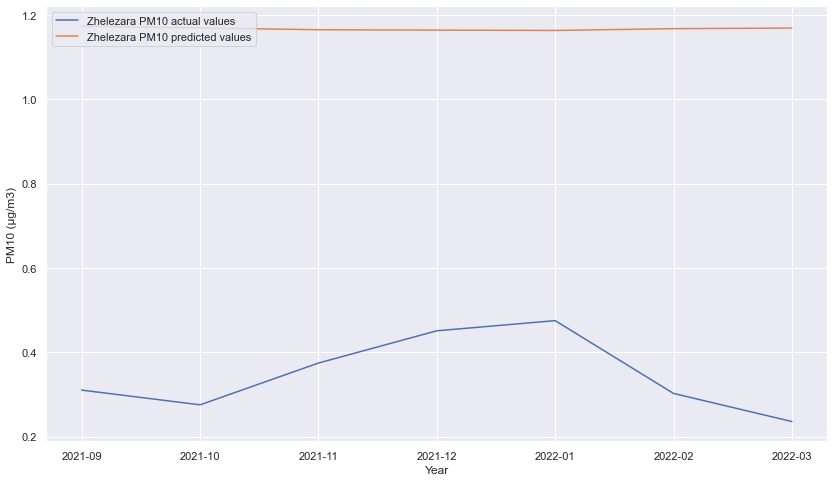

,sopishte_sensor_id,sopishte_lat,sopishte_log,bardovci_sensor_id,bardovci_lat,bardovci_log,crniche_sensor_id,crniche_lat,crniche_log,gjorche_stanica_sensor_id,...,Crniche PM10 actuals,Crniche PM10 predictions,Gjorche_stanica PM10 actuals,Gjorche_stanica PM10 predictions,11_oktomvri PM10 actuals,11_oktomvri PM10 predictions,Zhelezara PM10 actuals,Zhelezara PM10 predictions,Year,YM
date_time,,,,,,,,,,,,,,,,,,,,,
2021-09-26 13:15:00,6380c7cc-df23-4512-ad10-f2b363000579,41.960416,21.43482,01440b05-255d-4764-be87-bdf135f32289,42.027619,21.38742,24eaebc2-ca62-49ff-8b22-880bc131b69f,41.979767,21.433951,b80e5cd2-76cb-40bf-b784-2a0a312e6264,...,0.483393,0.625650,0.146617,0.653265,0.233940,0.487201,0.310394,1.172955,2021,2021-09
2021-09-26 13:30:00,6380c7cc-df23-4512-ad10-f2b363000579,41.960416,21.43482,01440b05-255d-4764-be87-bdf135f32289,42.027619,21.38742,24eaebc2-ca62-49ff-8b22-880bc131b69f,41.979767,21.433951,b80e5cd2-76cb-40bf-b784-2a0a312e6264,...,0.501946,0.628086,0.362546,0.654331,0.233940,0.486215,0.310394,1.175014,2021,2021-09
2021-09-26 13:45:00,6380c7cc-df23-4512-ad10-f2b363000579,41.960416,21.43482,01440b05-255d-4764-be87-bdf135f32289,42.027619,21.38742,24eaebc2-ca62-49ff-8b22-880bc131b69f,41.979767,21.433951,b80e5cd2-76cb-40bf-b784-2a0a312e6264,...,0.501946,0.625898,0.513695,0.654742,0.265288,0.486292,0.310394,1.171233,2021,2021-09
2021-09-26 14:00:00,6380c7cc-df23-4512-ad10-f2b363000579,41.960416,21.43482,01440b05-255d-4764-be87-bdf135f32289,42.027619,21.38742,24eaebc2-ca62-49ff-8b22-880bc131b69f,41.979767,21.433951,b80e5cd2-76cb-40bf-b784-2a0a312e6264,...,0.520500,0.624239,0.448917,0.653208,0.092879,0.485468,0.310394,1.168882,2021,2021-09
2021-09-26 14:15:00,6380c7cc-df23-4512-ad10-f2b363000579,41.960416,21.43482,01440b05-255d-4764-be87-bdf135f32289,42.027619,21.38742,24eaebc2-ca62-49ff-8b22-880bc131b69f,41.979767,21.433951,b80e5cd2-76cb-40bf-b784-2a0a312e6264,...,0.464840,0.625700,0.535288,0.653484,0.202593,0.486861,0.310394,1.171950,2021,2021-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-02 22:45:00,6380c7cc-df23-4512-ad10-f2b363000579,41.960416,21.43482,01440b05-255d-4764-be87-bdf135f32289,42.027619,21.38742,24eaebc2-ca62-49ff-8b22-880bc131b69f,41.979767,21.433951,b80e5cd2-76cb-40bf-b784-2a0a312e6264,...,0.334968,0.629151,0.103432,0.653662,0.249614,0.485030,0.198527,1.170642,2022,2022-03
2022-03-02 23:00:00,6380c7cc-df23-4512-ad10-f2b363000579,41.960416,21.43482,01440b05-255d-4764-be87-bdf135f32289,42.027619,21.38742,24eaebc2-ca62-49ff-8b22-880bc131b69f,41.979767,21.433951,b80e5cd2-76cb-40bf-b784-2a0a312e6264,...,0.353521,0.629088,0.189803,0.654606,0.110878,0.484687,0.002758,1.170426,2022,2022-03
2022-03-02 23:15:00,6380c7cc-df23-4512-ad10-f2b363000579,41.960416,21.43482,01440b05-255d-4764-be87-bdf135f32289,42.027619,21.38742,24eaebc2-ca62-49ff-8b22-880bc131b69f,41.979767,21.433951,b80e5cd2-76cb-40bf-b784-2a0a312e6264,...,0.297862,0.630093,0.125025,0.656368,0.124226,0.486467,0.058692,1.173948,2022,2022-03


In [324]:
plot_predictions(model, X_test, y_test, y_test_df)